In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F 


In [2]:
from bigram_network_train import load_raw_data, str_encoders

In [3]:
names_lines = load_raw_data()

In [4]:
stoi, itos = str_encoders(names_lines)

In [5]:
print(len(stoi), len(itos))

27 27


### Input Output prep

In [6]:
xs, ys = [], []
for name in names_lines:
    name = '..' + name + '.'
    for st in range(len(name))[:-2]:
        x = name[st:st+2]
        y = name[st+2]
        xs.append([stoi[i] for i in x])
        ys.append(stoi[y])

In [7]:
xs, ys = torch.tensor(xs), torch.tensor(ys)

In [9]:
randperm = torch.randperm(len(xs))

In [10]:
xs = xs[randperm]
ys = ys[randperm]

In [11]:

i80 = round(len(ys)*8/10)
i90 = round(len(ys)*9/10)
i80, i90

(182517, 205331)

In [12]:
xs_train, xs_dev, xs_test = xs[:i80], xs[i80:i90], xs[i90:]
ys_train, ys_dev, ys_test = ys[:i80], ys[i80:i90], ys[i90:]
print(xs_train.shape, xs_dev.shape, xs_test.shape)
print(ys_train.shape, ys_dev.shape, ys_test.shape)

torch.Size([182517, 2]) torch.Size([22814, 2]) torch.Size([22815, 2])
torch.Size([182517]) torch.Size([22814]) torch.Size([22815])


In [13]:
xs[:5]

tensor([[19,  5],
        [ 8,  1],
        [18, 25],
        [ 1, 14],
        [ 9, 12]])

In [14]:
x_enc = F.one_hot(xs, num_classes=len(stoi)).reshape(-1, 2*len(stoi)).float()

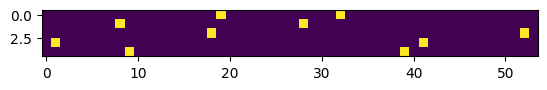

In [15]:
plt.imshow(x_enc[0:5])

In [16]:
class TrigramModel:
    
    @staticmethod
    def nll(likelihood):
        return -1*torch.log(likelihood)
    
    def __init__(self, stoi, itos, reg_wt) -> None:
        self.stoi = stoi
        self.itos = itos
        self.g = torch.Generator().manual_seed(1234)
        self.W = torch.randn(2*len(stoi), len(stoi), generator=self.g, requires_grad=True)
        self.W.grad = None
        self.reg_wt = reg_wt
        
    def encode(self, xs):
        return F.one_hot(xs, num_classes=len(self.stoi)).reshape(-1, 2*len(self.stoi)).float()
        
    def forward(self, xs):
        x_enc = self.encode(xs)
        logits = x_enc @ self.W
        counts = logits.exp()
        return counts/counts.sum(1, keepdim=True)
        
    def loss(self, probs, ys):
        likelihood = probs[torch.arange(len(ys)), ys]
        return self.nll(likelihood).mean() + self.reg_wt*(self.W**2).mean()
    
    def step(self, lr):
        self.W.data += -1*lr*self.W.grad
        
    def run(self, xs, ys, num, lr):
        losses = []
        for _ in range(num):
            self.W.grad = None
            probs = self.forward(xs)
            loss = self.loss(probs, ys)
            loss.backward()
            self.step(lr)
            losses.append(loss.item())
            
        return losses

---------- rwt = 0 -------------


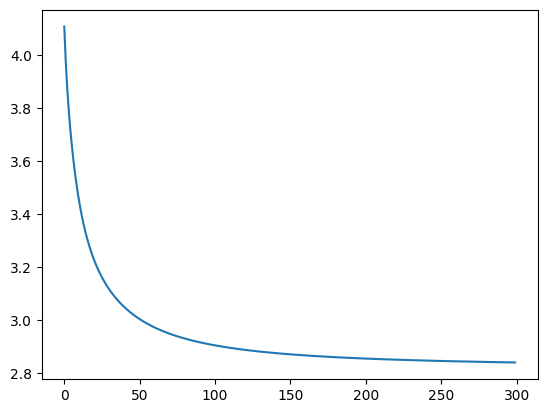

train loss is 2.8410377502441406
dev loss is 2.8458683490753174


In [17]:
for rwt in [0]:#, 0.1, 0.5, 1, 5]:
    print(f'---------- rwt = {rwt} -------------')
    model = TrigramModel(stoi, itos, rwt)

    losses = model.run(xs_train, ys_train, 300, 10)

    plt.plot(losses)
    plt.show()
    print(f"train loss is {model.loss(model.forward(xs_train), ys_train)}")
    print(f"dev loss is {model.loss(model.forward(xs_dev), ys_dev)}")
    

In [28]:
class TrigramModelWSelection:
    
    @staticmethod
    def nll(likelihood):
        return -1*torch.log(likelihood)
    
    def __init__(self, stoi, itos, reg_wt) -> None:
        self.stoi = stoi
        self.itos = itos
        self.g = torch.Generator().manual_seed(1234)
        self.W = torch.randn(2*len(stoi), len(stoi), generator=self.g, requires_grad=True)
        self.W.grad = None
        self.reg_wt = reg_wt
        
    def encode(self, xs):
        return F.one_hot(xs, num_classes=len(self.stoi)).reshape(-1, 2*len(self.stoi)).float()
        
    def forward(self, xs):
        x_enc = self.encode(xs)
        logits = x_enc @ self.W
        counts = logits.exp()
        return counts/counts.sum(1, keepdim=True)
        
    def loss(self, probs, ys):
        likelihood = probs[torch.arange(len(ys)), ys]
        return self.nll(likelihood).mean() + self.reg_wt*(self.W**2).mean()
    
    def step(self, lr):
        self.W.data += -1*lr*self.W.grad
        
    def run(self, xs, ys, num, lr):
        losses = []
        for _ in range(num):
            self.W.grad = None
            probs = self.forward(xs)
            loss = self.loss(probs, ys)
            loss.backward()
            self.step(lr)
            losses.append(loss.item())
            
        return losses

SyntaxError: invalid syntax (2745754519.py, line 1)

In [30]:
model.W.shape

torch.Size([54, 27])

In [31]:
xs[5]

tensor([8, 5])

In [38]:
model.encode(xs[5]).shape

torch.Size([1, 54])

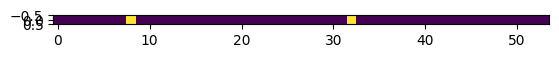

In [33]:
plt.imshow(model.encode(xs[5]))

In [34]:
model.encode(xs[5]) @ model.W

tensor([[ 1.8974,  1.9947, -0.3431, -0.5834,  0.2718,  1.5263, -1.6753, -1.3797,
          0.6130,  1.2669, -0.7033,  0.3233,  1.0929,  0.3429,  1.2617,  0.4796,
         -1.2039, -4.5576,  0.6683,  0.7219,  0.1222, -0.3238, -1.0181, -1.2042,
         -1.8964,  0.8161, -0.6085]], grad_fn=<MmBackward0>)

In [37]:
model.W.shape

torch.Size([54, 27])

In [36]:
model.W[xs[5]].shape

tensor([[ 1.0962e+00,  8.8438e-01,  3.9013e-01, -2.1023e-01,  4.7589e-01,
          8.2093e-01, -4.2945e-01, -1.8137e-01,  3.7493e-01,  8.2287e-01,
         -1.1164e-01,  6.4922e-01,  5.0669e-01, -1.9119e-02,  6.1825e-01,
          3.7989e-01,  1.0831e-01, -2.2419e+00,  3.3808e-01,  6.6995e-01,
          3.9945e-03,  3.5117e-02, -6.7691e-01, -1.2403e-01, -2.9920e-01,
          5.4421e-01, -1.3407e-01],
        [ 5.9116e-01,  3.3410e-01, -3.4186e-01, -5.9614e-01, -1.8276e-01,
          2.4267e-01, -1.7573e+00, -7.3889e-01, -1.9825e-01,  2.9772e-01,
         -5.2377e-01, -3.4124e-01,  9.4256e-02, -5.6723e-01,  2.3635e-01,
         -3.0125e-02, -1.0050e+00, -1.8870e+00,  8.1804e-02, -1.8155e-03,
         -6.5038e-01, -6.0025e-01, -8.4199e-01, -1.2241e+00, -1.8558e+00,
         -8.5173e-02, -9.4404e-01]], grad_fn=<IndexBackward0>)

---------- rwt = 0 -------------


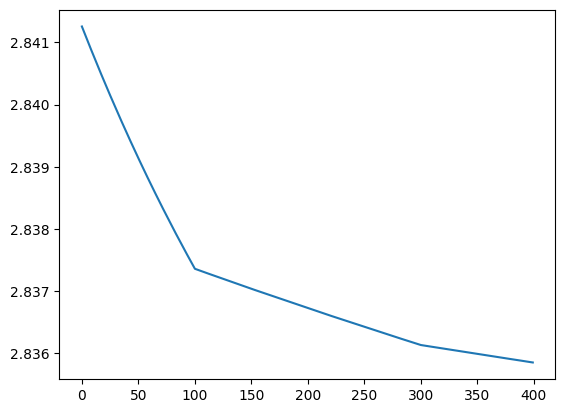

train loss is 2.8358473777770996
dev loss is 2.840399980545044
---------- rwt = 0.1 -------------


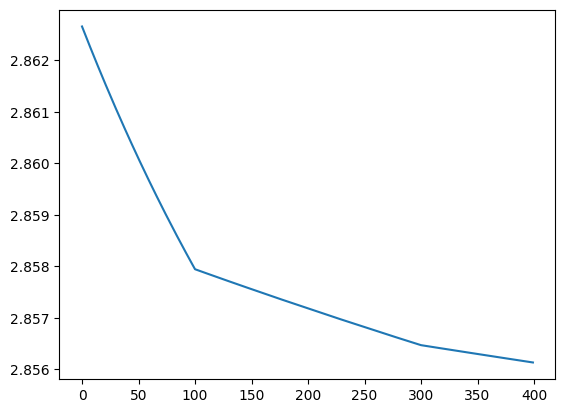

train loss is 2.856128454208374
dev loss is 2.860361099243164
---------- rwt = 0.5 -------------


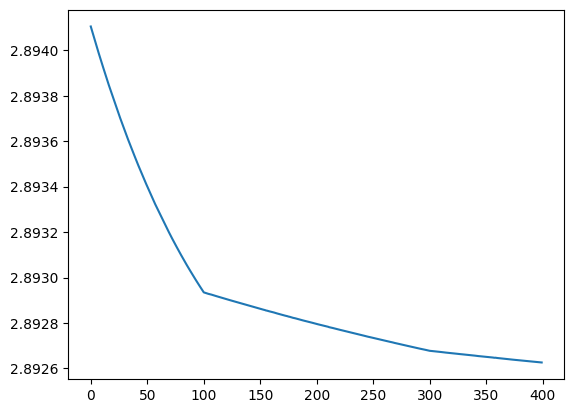

train loss is 2.892625570297241
dev loss is 2.8959548473358154
---------- rwt = 1 -------------


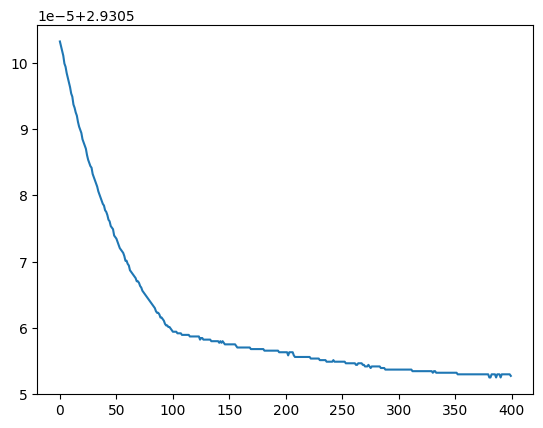

train loss is 2.9305529594421387
dev loss is 2.9334278106689453
---------- rwt = 5 -------------


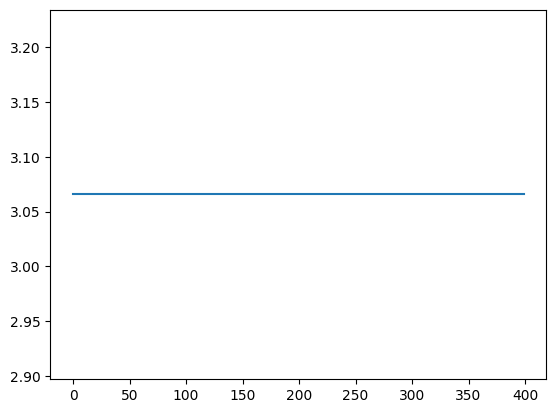

train loss is 3.0655577182769775
dev loss is 3.067424774169922


In [ ]:
for rwt in [0, 0.1, 0.5, 1, 5]:
    print(f'---------- rwt = {rwt} -------------')
    model = TrigramModel(stoi, itos, rwt)

    losses = model.run(xs_train, ys_train, 300, 10)
    losses = model.run(xs_train, ys_train, 100, 5)
    losses.extend(model.run(xs_train, ys_train, 200, 1))
    losses.extend(model.run(xs_train, ys_train, 100, 0.5))

    plt.plot(losses)
    plt.show()
    print(f"train loss is {model.loss(model.forward(xs_train), ys_train)}")
    print(f"dev loss is {model.loss(model.forward(xs_dev), ys_dev)}")
    

In [ ]:
print(f"train loss is {model.loss(model.forward(xs_train), ys_train)}")
print(f"dev loss is {model.loss(model.forward(xs_dev), ys_dev)}")

train loss is 2.860090732574463
dev loss is 2.864173412322998


In [ ]:
with torch.no_grad():
    names = []
    for i in range(10):
        name = '..'
        while(True):
            input_str = name[-2:]
            xs = torch.tensor([stoi[i] for i in input_str])
            probs = model.forward(xs)
            output_char = itos[torch.multinomial(probs, 1, replacement=True, generator=model.g).item()]
            if output_char == '.':
                name = name[2:]
                break
            else:
                name += output_char
        names.append(name)
        


In [ ]:
names

['miqtra',
 'enela',
 'b',
 'lra',
 'at',
 'yo',
 'uknnbjiuii',
 'n',
 'aiaaryosrkiamdni',
 'avbey']